# Implementation: K-Means & Cluster Labeling

In [1]:
import numpy as np

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2, axis=-1))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y), axis=-1)

def cosine_distance(x, y):
    # Normalize x and y to unit vectors
    x_norm = x / np.linalg.norm(x, axis=-1, keepdims=True)
    y_norm = y / np.linalg.norm(y, axis=-1, keepdims=True)
    return 1 - np.dot(x_norm, y_norm.T)

def assign_clusters(X, centroids, distance_fn):
    if distance_fn == cosine_distance:
        distances = distance_fn(X, centroids)
    else:
        distances = np.array([distance_fn(X, centroid) for centroid in centroids]).T
    return np.argmin(distances, axis=1)

def compute_centroids(X, labels, k):
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])

def k_means(X, k, distance='euclidean', max_iters=100, tol=1e-4):
    # Map distance function names to actual functions
    distance_functions = {
        'euclidean': euclidean_distance,
        'manhattan': manhattan_distance,
        'cosine': cosine_distance
    }

    distance_fn = distance_functions[distance]

    # Randomly initialize k distinct centroids from the data points X
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for i in range(max_iters):
        old_centroids = centroids

        labels = assign_clusters(X, centroids, distance_fn)
        # Recompute centroids as the mean of all data points assigned to each cluster
        centroids = compute_centroids(X, labels, k)
        # Check for convergence
        if np.all(np.linalg.norm(centroids - old_centroids, axis=1) < tol):
            break

    return centroids, labels

In [2]:
def calculate_accuracy(conf_matrix):
    correct_predictions = np.trace(conf_matrix)
    total_samples = np.sum(conf_matrix)
    accuracy = correct_predictions / total_samples
    return accuracy

def construct_table(y_kmeans, y, n_clusters):
    # Rows are labels and columns are cluster ids
    table = np.zeros((n_clusters, n_clusters))
    for i in range(len(y_kmeans)):
        label = y[i]
        cluster_id = y_kmeans[i]
        table[label][cluster_id] += 1
    return table

def sort_matrix(matrix):
    # Flatten the matrix along with their indices
    flattened_matrix = [(i, j, matrix[i][j]) for i in range(matrix.shape[0]) for j in range(matrix.shape[1])]

    # Sort the flattened matrix by the values in descending order
    return sorted(flattened_matrix, key=lambda x: x[2], reverse=True)

def label_clusters(y_kmeans, y, n_clusters):
    table = construct_table(y_kmeans, y, n_clusters)

    sorted_matrix = sort_matrix(table)

    # Contains the corresponding labels of the clusters
    cluster_labels = np.full(n_clusters, -1)
    assigned_labels = set()

    for label, cluster_id, _ in sorted_matrix:
        if cluster_labels[cluster_id] == -1 and label not in assigned_labels:
            assigned_labels.add(label)
            cluster_labels[cluster_id] = label
            if len(assigned_labels) == n_clusters:
                break
    return table, cluster_labels

# Implementation Test

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_table(table, labels=None, clusters=None):
    if labels is None:
        labels = list(range(table.shape[0]))
    if clusters is None:
        clusters = list(range(table.shape[0]))

    plt.figure(figsize=(12, 10))
    sns.heatmap(table, annot=True, fmt=".0f", cmap="Reds", xticklabels=clusters, yticklabels=labels, cbar=True)
    plt.xlabel('Cluster IDs')
    plt.ylabel('Labels')
    plt.title('Labeling of Clusters')
    plt.show()

def plot_confusion_matrix(confusion_matrix, labels=None):
    if labels is None:
        labels = list(range(confusion_matrix.shape[0]))

    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="BuGn", xticklabels=labels, yticklabels=labels, cbar=True)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

# Flatten the data
X = X.reshape(-1, 28 * 28)

11490434/11490434 [==============================] - 0s 0us/step


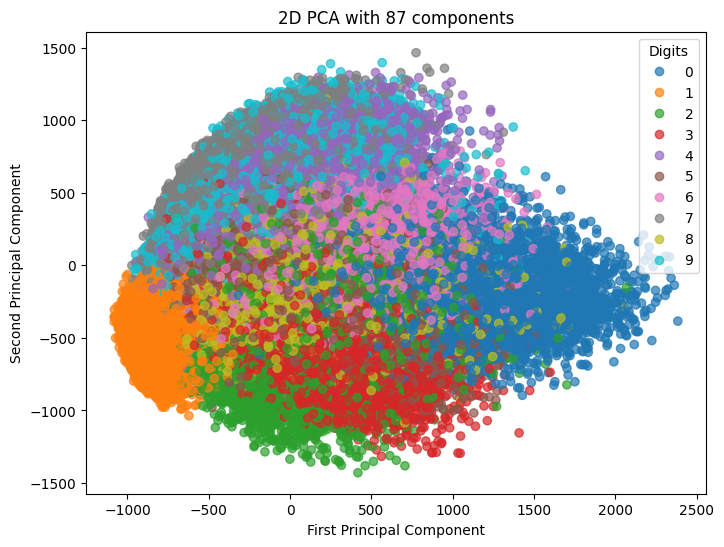

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.90)  # Retain 90% of variance
X_pca = pca.fit_transform(X)
n_components = X_pca.shape[1]

# Plot first vs second principal component
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'2D PCA with {n_components} components')
legend = plt.legend(*scatter.legend_elements(), title="Digits")
plt.show()

In [6]:
from sklearn.metrics import confusion_matrix

n_clusters = 10

clusters, y_kmeans = k_means(X_pca, n_clusters)

table, cluster_labels = label_clusters(y_kmeans, y, n_clusters)
y_kmeans_labeled = np.array([cluster_labels[cluster_id] for cluster_id in y_kmeans])

conf_matrix = confusion_matrix(y, y_kmeans_labeled)
accuracy = calculate_accuracy(conf_matrix)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.507


In [7]:
for i, label in enumerate(cluster_labels):
    print(f"cluster {i}: {label}")

cluster 0: 7
cluster 1: 4
cluster 2: 8
cluster 3: 6
cluster 4: 9
cluster 5: 0
cluster 6: 5
cluster 7: 3
cluster 8: 2
cluster 9: 1


In [8]:
np.unique(cluster_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

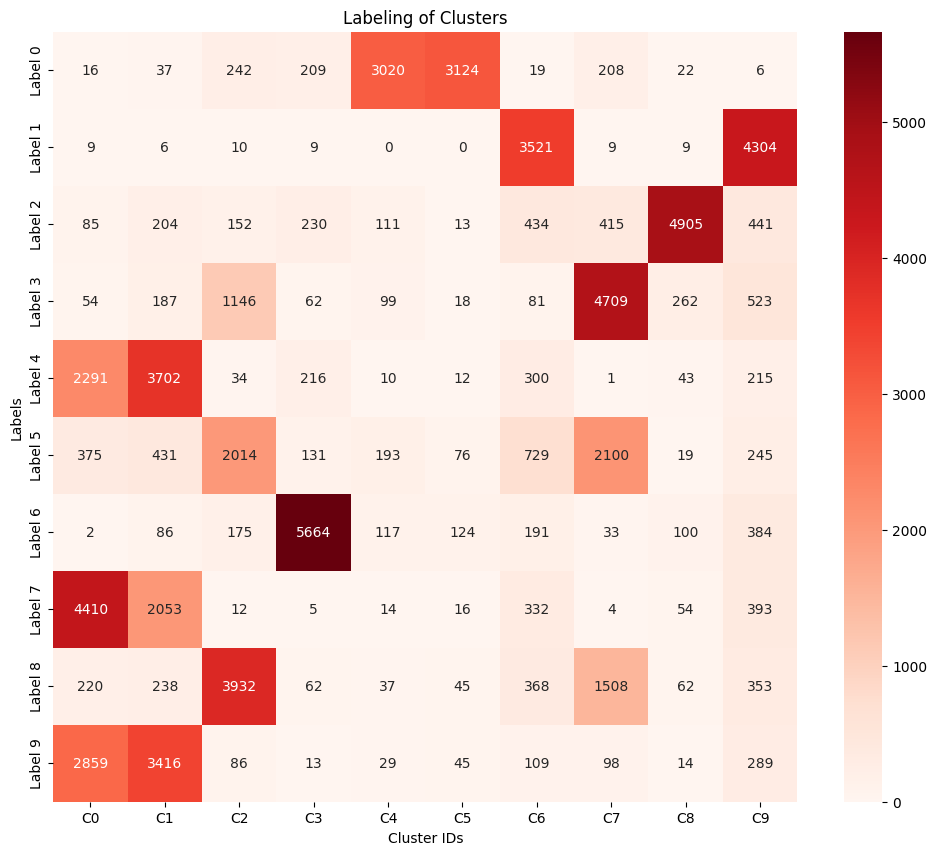

In [9]:
plot_table(table, labels=[f"Label {i}" for i in range(10)], clusters=[f"C{i}" for i in range(n_clusters)])

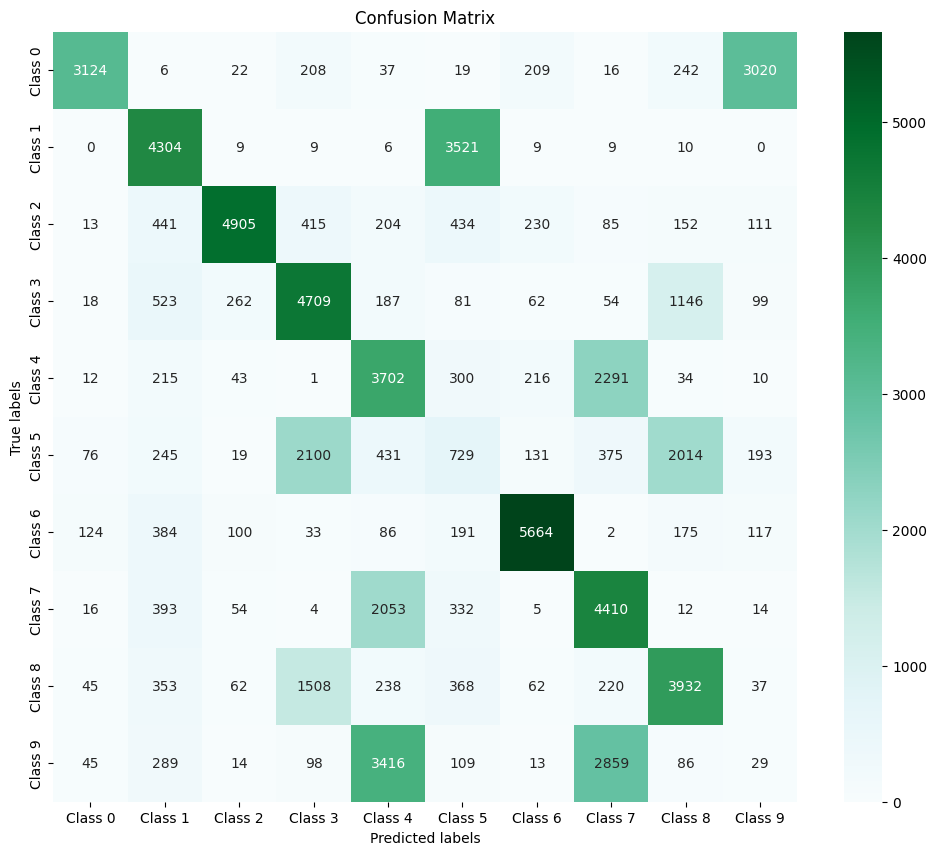

In [10]:
plot_confusion_matrix(conf_matrix, labels=[f"Class {i}" for i in range(n_clusters)])

In [11]:
from sklearn.metrics import confusion_matrix
k = 10

for distance in ['euclidean', 'manhattan', 'cosine']:
    centroids, y_kmeans = k_means(X_pca, k, distance=distance)
    table, cluster_labels = label_clusters(y_kmeans, y, n_clusters)
    y_kmeans_labels = np.array([cluster_labels[cluster_id] for cluster_id in y_kmeans])
    conf_matrix = confusion_matrix(y, y_kmeans_labels)
    accuracy = calculate_accuracy(conf_matrix)
    print(f"Distance Metric: {distance}, Accuracy: {accuracy:.3f}")

Distance Metric: euclidean, Accuracy: 0.542
Distance Metric: manhattan, Accuracy: 0.512
Distance Metric: cosine, Accuracy: 0.528


# Results

In [12]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

# Flatten the data
X = X.reshape(-1, 28 * 28)

In [13]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

k = 10  # Number of clusters for the k-means algorithm

# K-Fold cross-validation for training data
kf = KFold(n_splits=5, shuffle=True)

# PCA dimensionality reduction
pca = PCA(n_components=0.90)  # Retain 90% of variance
X_pca = pca.fit_transform(X)

# Initialize dictionaries to store accuracies for each distance
train_accuracies = {'euclidean': [], 'manhattan': [], 'cosine': []}
test_accuracies = {'euclidean': [], 'manhattan': [], 'cosine': []}

fold = 1
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Fold {fold}:")
    for distance in ['euclidean', 'manhattan', 'cosine']:
        # Apply clustering
        centroids, y_kmeans = k_means(X_train, k, distance=distance)

        # Label the clusters
        _, cluster_labels = label_clusters(y_kmeans, y_train, n_clusters=k)
        y_kmeans_labeled = np.array([cluster_labels[cluster_id] for cluster_id in y_kmeans])

        # Training error
        conf_matrix_train = confusion_matrix(y_train, y_kmeans_labeled)
        train_accuracy = calculate_accuracy(conf_matrix_train)
        train_accuracies[distance].append(train_accuracy)

        # Test error: fit 1-NN model on the training dataset with k-means labels
        knn_classifier = KNeighborsClassifier(n_neighbors=1)
        knn_classifier.fit(X_train, y_kmeans_labeled)
        y_pred = knn_classifier.predict(X_test)

        conf_matrix_test = confusion_matrix(y_test, y_pred)
        test_accuracy = calculate_accuracy(conf_matrix_test)
        test_accuracies[distance].append(test_accuracy)

        # Print or store the results as required
        print(f"Distance: {distance}, Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}")

    # Continue with the next fold
    fold += 1

# Print average accuracies per distance
for distance in ['euclidean', 'manhattan', 'cosine']:
    print(f"\nAverage Train Accuracy ({distance}): {np.mean(train_accuracies[distance]):.3f}")
    print(f"Average Test Accuracy ({distance}): {np.mean(test_accuracies[distance]):.3f}")

Fold 1:
Distance: euclidean, Train Accuracy: 0.511, Test Accuracy: 0.524
Distance: manhattan, Train Accuracy: 0.509, Test Accuracy: 0.522
Distance: cosine, Train Accuracy: 0.552, Test Accuracy: 0.564
Fold 2:
Distance: euclidean, Train Accuracy: 0.556, Test Accuracy: 0.558
Distance: manhattan, Train Accuracy: 0.529, Test Accuracy: 0.535
Distance: cosine, Train Accuracy: 0.554, Test Accuracy: 0.562
Fold 3:
Distance: euclidean, Train Accuracy: 0.539, Test Accuracy: 0.545
Distance: manhattan, Train Accuracy: 0.526, Test Accuracy: 0.534
Distance: cosine, Train Accuracy: 0.575, Test Accuracy: 0.583
Fold 4:
Distance: euclidean, Train Accuracy: 0.491, Test Accuracy: 0.495
Distance: manhattan, Train Accuracy: 0.504, Test Accuracy: 0.506
Distance: cosine, Train Accuracy: 0.490, Test Accuracy: 0.496
Fold 5:
Distance: euclidean, Train Accuracy: 0.557, Test Accuracy: 0.564
Distance: manhattan, Train Accuracy: 0.577, Test Accuracy: 0.586
Distance: cosine, Train Accuracy: 0.529, Test Accuracy: 0.537


# Conclusion

In conclusion, our methodology commenced with the application of Principal Component Analysis (PCA) to reduce the dimensionality of the dataset from 784 to 87 dimensions, thereby capturing 90% of the proportion of variance (PoV). Subsequently, we employed the k-means clustering algorithm on each fold of a 5-fold cross-validation setup, exploring three different distance metrics. Each cluster within this setup was labeled from 0 to 9, aligning with the classes of the MNIST dataset. These labeled clusters were then used to train a 1-Nearest Neighbor (1-NN) classifier for each training fold.

The performance of the 1-NN classifiers was evaluated on their respective test folds. We observed that while the average 5-fold cross-validation scores for the three distance metrics were relatively close, a clear hierarchy in performance emerged. The cosine similarity metric proved to be the most effective, achieving an accuracy of 0.548, followed by the Euclidean metric at 0.537 accuracy, and the Manhattan metric at 0.536.

Cosine similarity, primarily known for its extensive use in text analysis and word embeddings, excels in scenarios where the orientation and pattern of data points are more significant than their absolute magnitudes. Performance of this metric's in our image classification task underscores its versatility and adaptability across different domains, including those beyond its traditional applications in text data.

The Euclidean distance, which measures the straight-line distance between two points in multi-dimensional space, remains the most intuitively appealing and widely used metric. Its effectiveness across a wide array of applications, from clustering to complex neural networks, is notable. In the context of the MNIST dataset, although slightly outperformed by cosine similarity, its simplicity and direct geometric interpretation make it a robust and reliable choice, particularly suitable for tasks involving dense, high-dimensional data like image processing. This inherent robustness, aligned with intuitive notions of distance and similarity, ensures its continued utility in various clustering and classification tasks.